### NCEM

This script uses 10X Visium Breast Cancer Spatial Data and single cell Breast Cancer reference data for Cell2Location. 

##### NCEM Libraries

In [2]:
%load_ext autoreload
%autoreload 2

import ncem as nc
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import pandas as pd
from anndata import AnnData
from itertools import combinations
import stlearn as st

import cell2location
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel
import scvi
import copy

from ncem.interpretation import InterpreterDeconvolution
from ncem.train import TrainModelLinearDeconvolution
from ncem.data import get_data_custom, customLoaderDeconvolution, customLoader
from ncem.interpretation import InterpreterInteraction
print(f"ncem=={nc.__version__}")

sc.settings.set_figure_params(dpi=80)
import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ncem==0.1.4


##### NCEM Pipeline

Added tissue image to the object!
(3813, 33538)


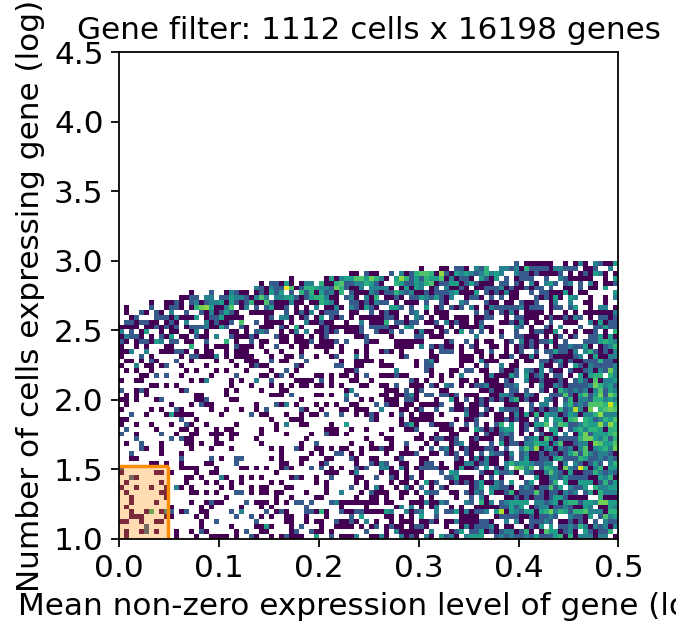

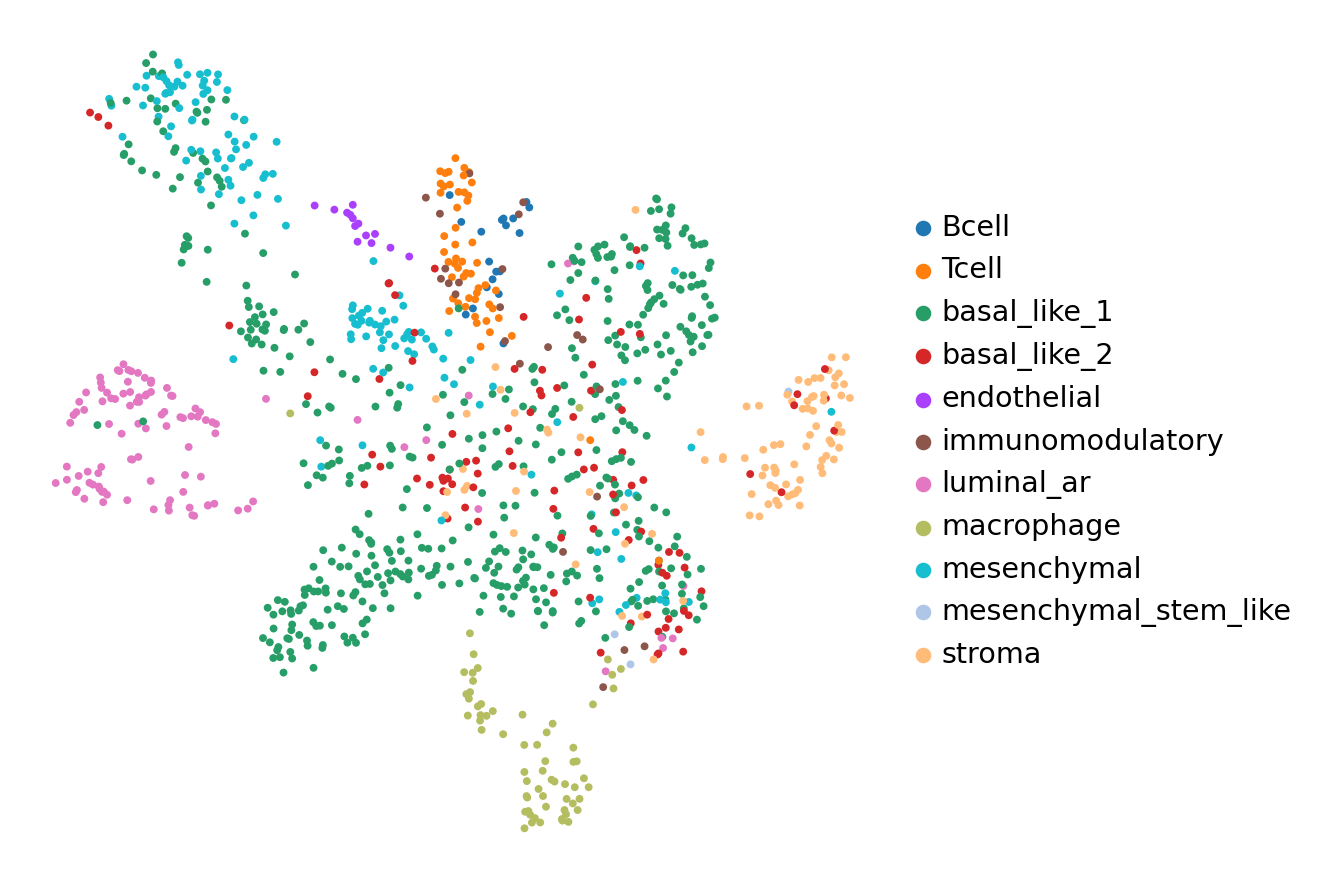

In [3]:
#adata_vis = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")
#lieden_cluster = pd.read_csv("/home/uqomulay/90days/stLearn_rebuttal/bc_leiden_cluster.csv",index_col=0)
#adata_vis = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")
#adata_vis = adata_vis[adata_vis.obs.index.isin(lieden_cluster.index)]

data_dir = "/afm01/UQ/Q1851/Jon/Human_Breast_Cancer_Block_A_Section_1/"
adata_vis = st.Read10X(data_dir)
adata_vis.var_names_make_unique()
st.add.image(adata=adata_vis,
             imgpath=data_dir+"spatial/tissue_hires_nobg.png",
             library_id="V1_Breast_Cancer_Block_A_Section_1", visium=True)

print(adata_vis.shape)
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names
#adata_vis.var_names = adata_vis.var['gene_ids']
#adata_vis.var_names.name = None

# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

# Read data
adata_ref = sc.read('/afm01/UQ/Q1851/Brad/breast_sc.h5ad')

# Use ENSEMBL as gene IDs to make sure IDs are unique and correctly matched


selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:, selected].copy()


adata_ref.obs['ncem_cluster'] = list(
    adata_ref.obs['cell_type']
)

sc.set_figure_params(scanpy=True)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(7,7),
)
sc.pl.umap(
    adata_ref, color='ncem_cluster', ax=ax, show=False, size=50,title="",
    frameon=False
)
plt.show()


#### Estimation of reference Cell-type signatures (NB Regression)

In [4]:
ref_adata = AnnData(adata_ref.to_df().astype('int64'))
ref_adata.obs = adata_ref.obs
ref_adata.var = adata_ref.var
ref_adata.uns = adata_ref.uns
ref_adata.obsm = adata_ref.obsm
ref_adata.varm = adata_ref.varm
ref_adata.obsp = adata_ref.obsp

RegressionModel.setup_anndata(
    adata=ref_adata,
    labels_key='ncem_cluster',
)

mod = RegressionModel(ref_adata)
#Training ========================================
mod.train(max_epochs=250, batch_size=750, train_size=1, lr=0.002, use_gpu=False)

adata_ref = mod.export_posterior(
    ref_adata, sample_kwargs={'num_samples': 1000, 'batch_size': 500, 'use_gpu': False}
)
if 'means_per_cluster_mu_fg' in ref_adata.varm.keys():
    inf_aver = ref_adata.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in ref_adata.uns['mod']['factor_names']]].copy()
else:
    inf_aver = ref_adata.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in ref_adata.uns['mod']['factor_names']]].copy()
inf_aver.columns = ref_adata.uns['mod']['factor_names']


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [03:31<00:00,  1.21it/s, v_num=1, elbo_train=1.35e+7]

`Trainer.fit` stopped: `max_epochs=250` reached.


Sampling global variables, sample: 100%|██████████| 999/999 [00:41<00:00, 24.08it/s]


#### Cell2Location: Spatial Mapping

In [5]:
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
duplicates = list(set([i for i in list(adata_vis.var.index) if list(adata_vis.var.index).count(i) == 2]))
intersect_genes = [i for i in intersect if i not in duplicates]
inf_aver = inf_aver.loc[intersect_genes, :].copy()
#inf_aver = inf_aver.reindex(adata_vis.var_names)

vis_adata = AnnData(adata_vis.to_df().loc[:,intersect_genes])
vis_adata.obs = adata_vis.obs
vis_adata.var = adata_vis.var[adata_vis.var.index.isin(intersect_genes)]
vis_adata.uns = adata_vis.uns
vis_adata.obsm = adata_vis.obsm

del(adata_vis)
adata_vis = vis_adata.copy()

cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")
inf_aver = inf_aver.reindex(adata_vis.var_names)
print(np.all(adata_vis.var_names == inf_aver.index))
inf_aver

True


,Bcell,Tcell,basal_like_1,basal_like_2,endothelial,immunomodulatory,luminal_ar,macrophage,mesenchymal,mesenchymal_stem_like,stroma
FAM138A,0.000277,0.000279,0.040747,0.000277,0.000279,0.000275,0.000278,0.000281,0.000279,0.000280,0.000278
OR4F29,0.000278,0.065873,0.008686,0.000283,0.000280,0.000280,0.000278,0.000282,0.000278,0.000280,0.000280
OR4F16,0.000281,0.066834,0.008560,0.000281,0.000283,0.000283,0.000276,0.000277,0.000280,0.000278,0.000280
FAM87B,0.000283,0.104818,0.011501,0.016579,0.191089,0.000276,0.158029,0.055246,0.000283,0.000280,0.047090
LINC00115,0.291861,0.218881,0.080476,0.000279,0.000283,0.000283,0.100412,0.039287,0.240672,0.000280,0.100136
...,...,...,...,...,...,...,...,...,...,...,...
C21orf58,0.000283,0.000280,0.053243,0.016359,0.399522,0.154517,0.166635,0.000279,0.112449,0.000282,0.000275
PCNT,0.000277,0.739044,0.603795,0.387658,1.963783,0.764592,0.938540,1.105814,0.840842,0.000282,0.763025
DIP2A,0.290841,1.007076,0.695456,0.707906,2.224258,0.341466,0.642121,0.743313,1.259681,0.000280,0.643551
S100B,0.000281,0.000280,0.887397,0.413313,0.000280,0.197315,0.023200,0.119294,0.744409,0.000277,0.000278


#### Estimate cell-type specific expression of every gene in the spatial data

In [6]:
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    N_cells_per_location=30,
    detection_alpha=200
)
mod.train(
    max_epochs=7500, batch_size=None, train_size=1, use_gpu=False
)

adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']


expected_dict = mod.module.model.compute_expected_per_cell_type(mod.samples["post_sample_q05"], mod.adata_manager)
# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]
    
    
cell_types = list(inf_aver.columns)
label_transfer = pd.read_csv("/home/uqomulay/90days/stLearn_rebuttal/label_transfer_bc.csv", sep="\t")
label_transfer.drop(columns=["predicted.id","prediction.score.max"],inplace=True)
label_transfer = label_transfer[label_transfer.index.isin(adata_vis.obs.index)]
label_transfer.columns = label_transfer.columns.str[17:]
label_transfer = label_transfer.reindex(adata_vis.obs.index)
prop = label_transfer[cell_types]
#adata_vis.obs[cell_types]

cell_expression = []
node_types = []
proportions = []
spatial = []

for i, ct in enumerate(cell_types):
    proportions.append(prop)
    cell_expression.append(adata_vis.layers[ct].toarray())
    nt = np.zeros((prop.shape[0], len(cell_types)))
    nt[:, i] = 1
    node_types.append(nt)
    spatial.append(adata_vis.obsm['spatial'])
    
proportions = pd.DataFrame(np.concatenate(proportions), columns=cell_types)
cell_expression = pd.DataFrame(np.concatenate(cell_expression), columns=adata_vis.var_names)
node_types = pd.DataFrame(np.concatenate(node_types), columns=cell_types)
spatial = pd.DataFrame(np.concatenate(spatial))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 7500/7500: 100%|██████████| 7500/7500 [6:27:59<00:00,  3.18s/it, v_num=1, elbo_train=4.48e+7]  

`Trainer.fit` stopped: `max_epochs=7500` reached.


Sampling global variables, sample: 100%|██████████| 999/999 [03:41<00:00,  4.51it/s]


In [7]:
ad = AnnData(cell_expression)
ad.obsm['proportions'] = np.array(proportions)
ad.obsm['node_types'] = np.array(node_types)
ad.obsm['spatial'] = np.array(spatial)

ad.uns["node_type_names"] = {x: x for x in cell_types}

ad.var_names = adata_vis.var['SYMBOL'].values


sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=2000, subset=True,)

h_0 = pd.DataFrame(ad.obsm['node_types'], columns=list(ad.uns['node_type_names'].values()))
target_type = pd.DataFrame(np.array(h_0.idxmax(axis=1)), columns=["target_cell"]).reset_index()
ad.obs = target_type

ad
path = '/home/uqomulay/90days/stLearn_rebuttal/NCEM/'
fn = 'cell2location_bc_NCEM_2.h5ad'
ad.write(path + fn)

AnnData object with n_obs × n_vars = 41943 × 2000
    obs: 'index', 'target_cell'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'node_type_names', 'log1p', 'hvg'
    obsm: 'proportions', 'node_types', 'spatial'

### After Cell2location is completed - load the anndata for NCEM InterpreterDeconvolution

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Loaded 2 images with complete data from 1 patients over 41943 cells with 2000 cell features and 11 distinct celltypes.
Mean of mean node degree per images across images: 6.000000
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 41943 cells out of 2 images from 1 patients.
Test dataset: 4195 cells out of 2 images from 1 patients.
Training dataset: 34143 cells out of 2 images from 1 patients.
Validation dataset: 3774 cells out of 2 images from 1 patients. 

using ols parameters.
calculating inv fim.


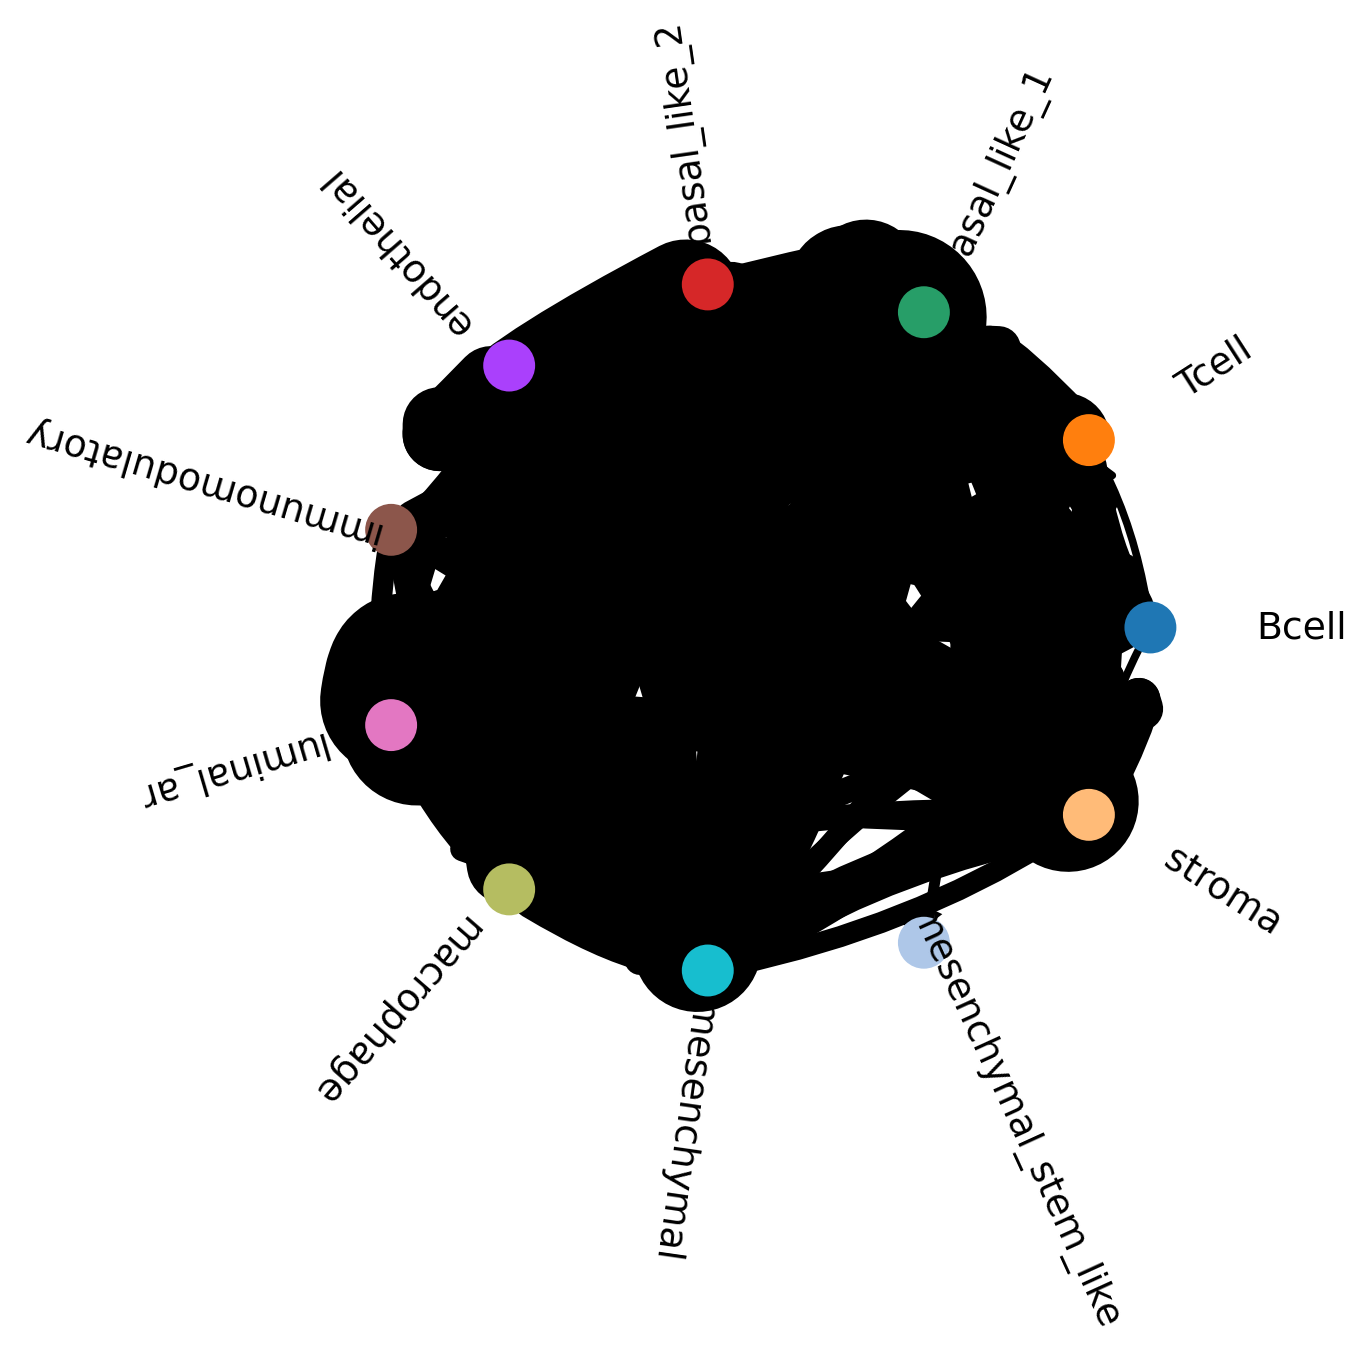

In [4]:
path = '/home/uqomulay/90days/stLearn_rebuttal/NCEM/'

adata = sc.read(path + 'cell2location_bc_NCEM_2.h5ad')
adata

random_library_id = np.random.randint(2, size=adata.shape[0])
adata.obs['library_id'] = pd.Categorical([f"image_{i}" for i in random_library_id])

ncem_ip = InterpreterDeconvolution()

ncem_ip.data = customLoaderDeconvolution(adata=adata, patient=None, 
                                         library_id='library_id', radius=None)

get_data_custom(interpreter=ncem_ip, deconvolution=True)

ncem_ip.get_sender_receiver_effects()

type_coupling = ncem_ip.type_coupling_analysis_circular(
    edge_attr='magnitude', 
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)
type_coupling.to_csv("/afm01/UQ/Q1851/Onkar/stLearn_rebuttal/Outputs/NCEM/Chordplot_Labeltransfer_LR_score_by_celltype.csv")

In [17]:
trainer = TrainModelLinearDeconvolution()
trainer.init_estim(log_transform=False)

trainer.estimator.data = customLoaderDeconvolution(adata=adata, patient=None, 
                                                   library_id='library_id', radius=None)

get_data_custom(interpreter=trainer.estimator, deconvolution=True)

trainer.estimator.init_model(n_eval_nodes_per_graph=10)
trainer.estimator.model.training_model.summary()

trainer.estimator.train(epochs=5)

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Loaded 2 images with complete data from 1 patients over 41943 cells with 2000 cell features and 11 distinct celltypes.
Mean of mean node degree per images across images: 6.000000
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 41943 cells out of 2 images from 1 patients.
Test dataset: 4195 cells out of 2 images from 1 patients.
Training dataset: 34143 cells out of 2 images from 1 patients.
Validation dataset: 3774 cells out of 2 images from 1 patients. 



2023-01-31 13:06:49.875447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2023-01-31 13:06:49.875510: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 13:06:49.875540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (delta080): /proc/driver/nvidia/version does not exist
2023-01-31 13:06:49.875839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appr

Model: "interaction_linear_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 interaction (InputLayer)       [(None, 10, 121)]    0           []                               
                                                                                                  
 target (InputLayer)            [(None, 10, 11)]     0           []                               
                                                                                                  
 denseinteraction (DenseInterac  (None, 10, 121)     0           ['interaction[0][0]']            
 tions)                                                                                           
                                                                                                  
 categorical_predictor (InputLa  [(None, 10, 0)]     0           []        

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1/1 - 10s - loss: 1905.5139 - custom_mae: 0.0988 - custom_mean_sd: 1.0000 - custom_mse: 0.0676 - custom_mse_scaled: 0.0676 - gaussian_reconstruction_loss: 1905.5139 - r_squared: -1.1424e-01 - r_squared_linreg: 1.8807e-06 - val_loss: 1901.3464 - val_custom_mae: 0.0937 - val_custom_mean_sd: 0.9999 - val_custom_mse: 0.0637 - val_custom_mse_scaled: 0.0637 - val_gaussian_reconstruction_loss: 1901.3464 - val_r_squared: -1.0705e-01 - val_r_squared_linreg: 1.4215e-06 - lr: 1.0000e-04 - 10s/epoch - 10s/step
Epoch 2/5
1/1 - 4s - loss: 1910.6000 - custom_mae: 0.1050 - custom_mean_sd: 0.9999 - custom_mse: 0.0729 - custom_mse_scaled: 0.0729 - gaussian_reconstruction_loss: 1910.6000 - r_squared: -1.2210e-01 - r_squared_linreg: 3.1215e-05 - val_loss: 1893.9836 - val_custom_mae: 0.0894 - val_custom_mean_sd: 0.9998 - val_custom_mse: 0.0565 - val_custom_mse_scaled: 0.0565 - val_gaussian_reconstruction_loss: 1893.9836 - val_r_squared: -1.0794e-01 - val_r_squared_linreg: 1.7860e-05 - lr: 1.0000e-04 - 4s/e

### Main LR results

In [11]:
cell_types = ["basal_like_1", "basal_like_2", "stroma", "mesenchymal","Tcell", "Bcell", "endothelial", "luminal_ar",
              "immunomodulatory", "mesenchymal_stem_like", "macrophage"]
LR_score_by_celltype = []
res = list(combinations(cell_types, 2))
for i in range(0,len(res)):
    df = ncem_ip.sender_receiver_values(receiver=res[i][0], sender=res[i][1])
    df["receiver_sender"] = [res[i][0]+"-"+res[i][1]]*len(df)
    LR_score_by_celltype.append(df)
for i in range(0,len(res)):
    df = ncem_ip.sender_receiver_values(receiver=res[i][1], sender=res[i][0])
    df["receiver_sender"] = [res[i][0]+"-"+res[i][1]]*len(df)
    LR_score_by_celltype.append(df)
for i in range(0,len(cell_types)):
    df = ncem_ip.sender_receiver_values(receiver=cell_types[i], sender=cell_types[i])
    df["receiver_sender"] = [cell_types[i]+"-"+cell_types[i]]*len(df)
    LR_score_by_celltype.append(df)
    
LR_score_by_celltype = pd.concat(LR_score_by_celltype)
LR_score_by_celltype.to_csv(path+"Labeltransfer_LR_score_by_celltype.csv")
LR_score_by_celltype

,mean expression,pvalue,qvalue,fold change,-log 10 qvalue,receiver_sender
FAM138A,0.772024,0.859409,1.00000,0.004347,-0.000000,basal_like_1-basal_like_2
OR4F29,0.052627,0.846426,1.00000,0.001247,-0.000000,basal_like_1-basal_like_2
RNF223,0.128083,0.916809,1.00000,0.001916,-0.000000,basal_like_1-basal_like_2
UBE2J2,0.101475,0.106934,0.49992,0.015890,0.301099,basal_like_1-basal_like_2
TAS1R3,0.000804,0.949406,1.00000,0.000578,-0.000000,basal_like_1-basal_like_2
...,...,...,...,...,...,...
UBASH3A,0.004700,0.779162,1.00000,0.003708,-0.000000,macrophage-macrophage
AIRE,0.000062,0.995880,1.00000,0.000031,-0.000000,macrophage-macrophage
COL6A1,0.005750,0.895063,1.00000,0.002293,-0.000000,macrophage-macrophage
MCM3AP-AS1,0.025365,0.762620,1.00000,0.005240,-0.000000,macrophage-macrophage


##### NCEM Plotting

In [ ]:
ncem_ip.receiver_effect(
    sender='Bcell', 
    gene_subset=['POU2AF1'], 
    figsize=(4,5)
)

ncem_ip.sender_effect(
    receiver='basal_like_1', 
    gene_subset=['POU2AF1'], 
    figsize=(4,5)
)

ncem_ip.type_coupling_analysis(figsize=(6.5, 5.5))

ncem_ip.type_coupling_analysis_circular(
    edge_attr='magnitude', 
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)